# Calibrated Explanations for Binary Classification
## Demonstrated on the diabetes data set

Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [Pima Indians Diabetes Database [kaggle]](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
2. ["Calibrated Explanations: with Uncertainty Information and Counterfactuals"](https://arxiv.org/abs/2305.02305) by [Helena Löfström](https://github.com/Moffran), [Tuwe Löfström](https://github.com/tuvelofstrom), Ulf Johansson, and Cecilia Sönströd.

### 1. Import packages, data and train an underlying model
#### 1.1 Import packages

In the examples below, we will be using `NumPy`, `pandas`, and `sklearn`.  `CalibratedExplainer` and `VennAbers` are imported from `calibrated_explanations`. `VennAbers` is used to demonstrate how it can be used to calibrate an underlying model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer, VennAbers, __version__

print(f"calibrated_explanations v. {__version__}")


c:\Users\loftuw\Anaconda3\envs\cp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


calibrated_explanations v. v0.0.16


#### 1.2 Import data and train a model
Let us import the Califronia Housing data set (see sources at the top).

In [3]:
dataSet = 'diabetes_full'
delimiter = ','
model = 'RF'
print(dataSet)

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Y'
X, y = df.drop(target,axis=1), df[target] 
df.head()

diabetes_full


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Y
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let us split the data set into a training and a test set, and further split the training set into a proper training set and a calibration set. 

In [4]:
num_to_test = 2 # number of instances to test, one from each class

no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

# find categorical features
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:,i])) < 10]

# select test instances from each class and split into train, cal and test
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)

print(testY)
print(categorical_features)

[0 1]
[]


Let us fit a random forest to the proper training set. We also set a random seed to be able to rerun the notebook and get the same results.

In [5]:
model = RandomForestClassifier()

model.fit(trainX,trainY)  

RandomForestClassifier()

Before extracting an explanation, lets see what the output from the model and from Venn-Abers (va) are for the test instances.

For an explanation of Venn-Abers, see Paulo Toccacellis Github repo [VennABERS](https://github.com/ptocca/VennABERS) or read the ["Calibrated Explanations: with Uncertainty Information and Counterfactuals"](https://arxiv.org/abs/2305.02305) paper introducing this package.

Outputs are probabilities for `class #1`. 

In [6]:
preds = model.predict(testX)
proba = model.predict_proba(testX)

va = VennAbers(model.predict_proba(calX), calY, model)  
va_preds = va.predict(testX)
va_proba, low, high = va.predict_proba(testX, output_interval=True)

print("Model: pred (proba) - Va: pred (proba) [interval] - Y")
for pred, proba, va_pred, va_proba, lo, hi, y in zip(preds, proba, va_preds, va_proba, low, high, testY):
    output_str = f"Model: {pred:g} ({proba[1]:.2f}) - Va: {va_pred:g} ({va_proba[1]:.2f}) [{lo:.2f}-{hi:.2f}] - {y}"
    print(output_str) 

Model: pred (proba) - Va: pred (proba) [interval] - Y
Model: 0 (0.06) - Va: 0 (0.06) [0.03-0.06] - 0
Model: 1 (0.70) - Va: 1 (0.74) [0.70-0.87] - 1


Create the `CalibratedExplainer` by feeding the model and the calibration set as a minimum (mode is 'classification' by default). 

In [7]:
ce = CalibratedExplainer(model, 
                         calX, 
                         calY,
                         feature_names=df.columns,                    
                         categorical_features=categorical_features, 
                         class_labels={0:'Non-diabetic',1:'Diabetic'})
display(ce)

CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'calibrated_explanations._discretizers.BinaryEntropyDiscretizer'>
	                model=RandomForestClassifier()
	                

#### Regular and uncertainty explanations
When using regular or uncertainty plots, the recommended (and for classification default) `Discretizer` is the `BinaryEntropyDiscretizer`. As no discretizer was assigned at initialization, it is already assigned `BinaryEntropyDiscretizer`. 

Once the explanations are extracted, we can visualize them using regular or uncertainty plots. The regular plot include an uncertainty interval for each class and the weights of the most influential features. The weights (positive or negative) always indicate the impact on the blue class. However, the colors are used to indicate which class is positively affected. Negative (red) weights are reducing the probability of the blue class and increasing the probability of the red class. 

Regular plots are shown by calling the function `plot_all`, with `n_features_to_show` indicating the number of features to include, in order of importance. To save the plots to disk, `save_ext` can take one or several of the following extensions `['pdf','svg','png']` creating a plot for each instance and file format. 

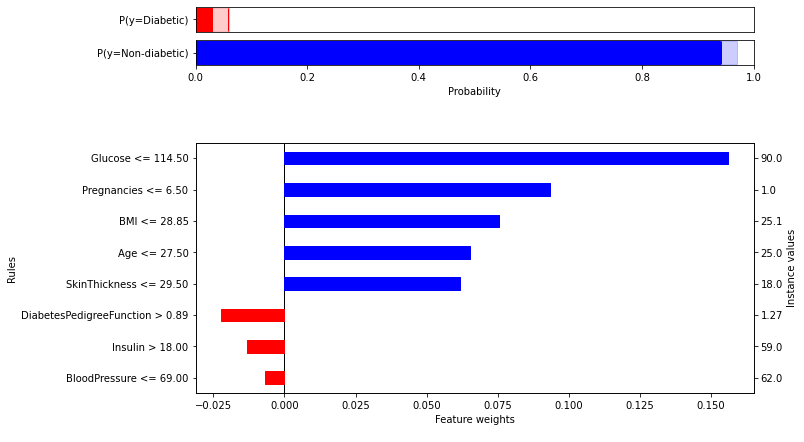

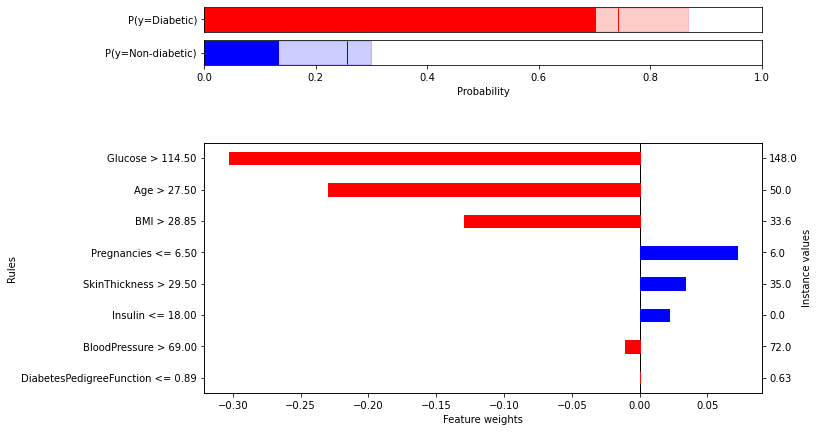

In [8]:
factual_explanation = ce.explain_factual(testX)
factual_explanation.plot_all()

Uncertainty plots are similar to regular plots but also provide an uncertainty estimate for the impact of each feature. Here, the shaded area is the range of possible changes that each feature can result in.

To get uncertainty plots, the `plot_uncertainty` function can be called with the same parameters as `plot_all`.

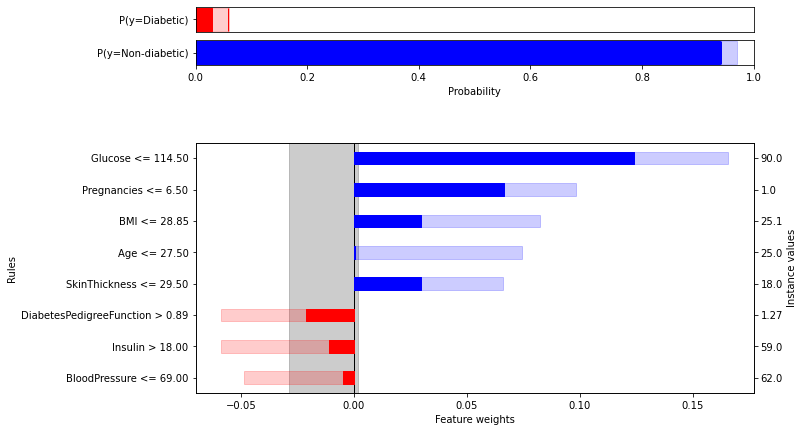

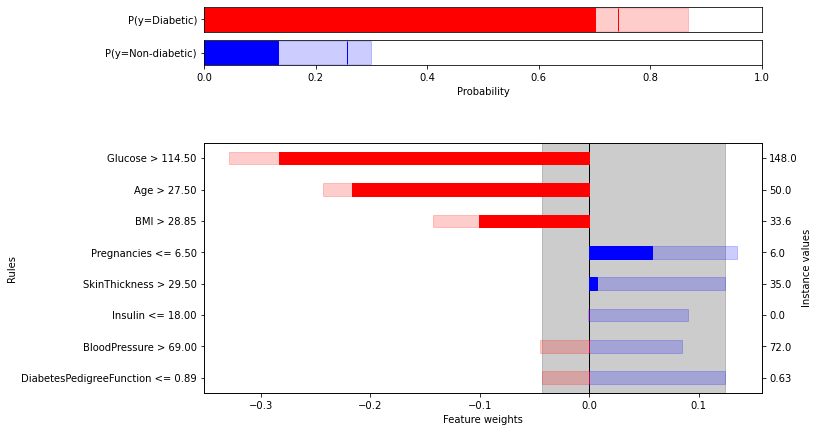

In [9]:
factual_explanation.plot_all(uncertainty=True)

#### Conjunctive rules
In the examples above, each explanation only contained atomic rules, including a single feature. It is also possible to combine rules and see the combined impact of more than one feature.

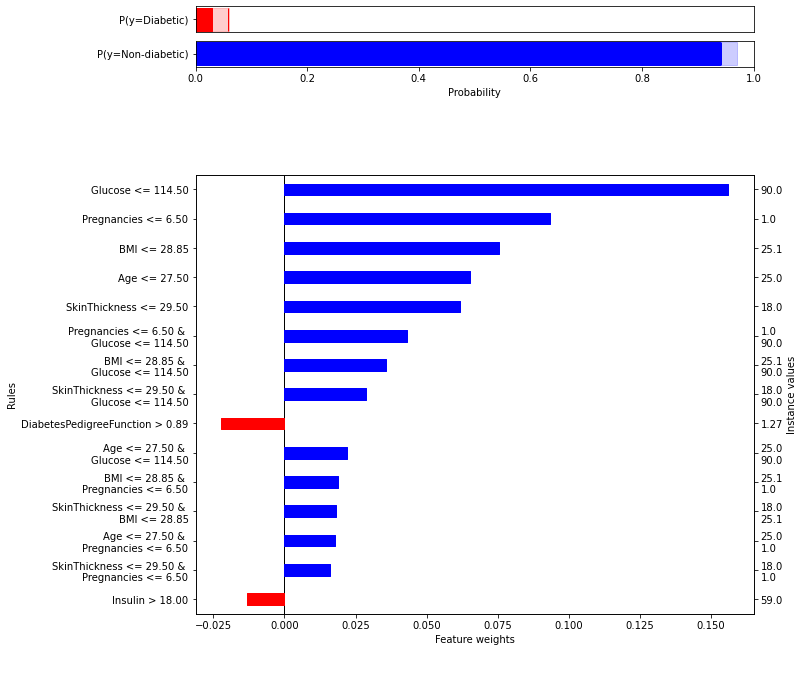

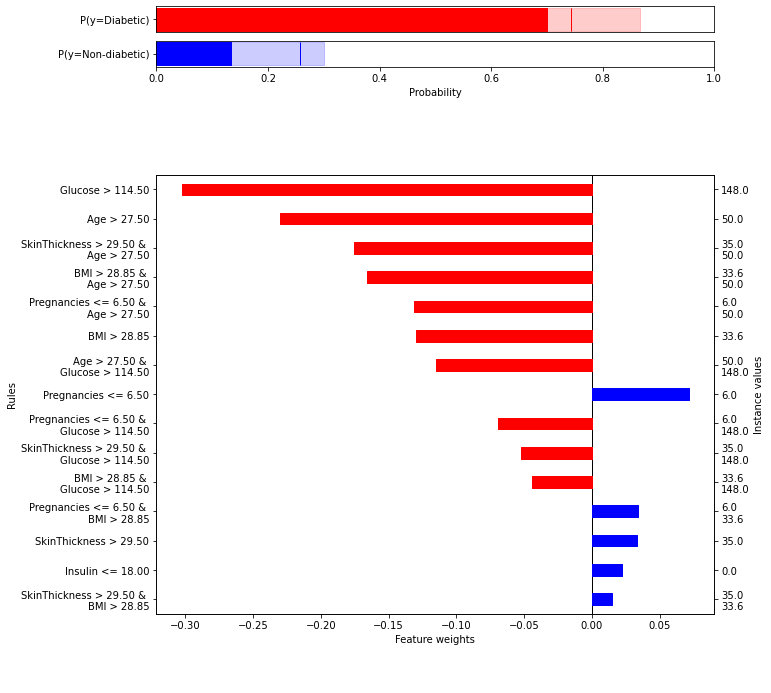

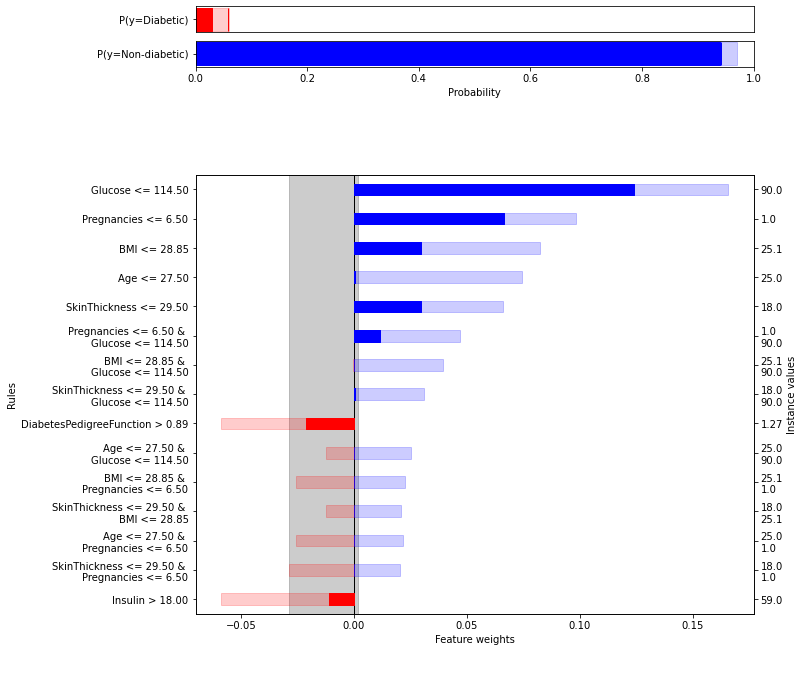

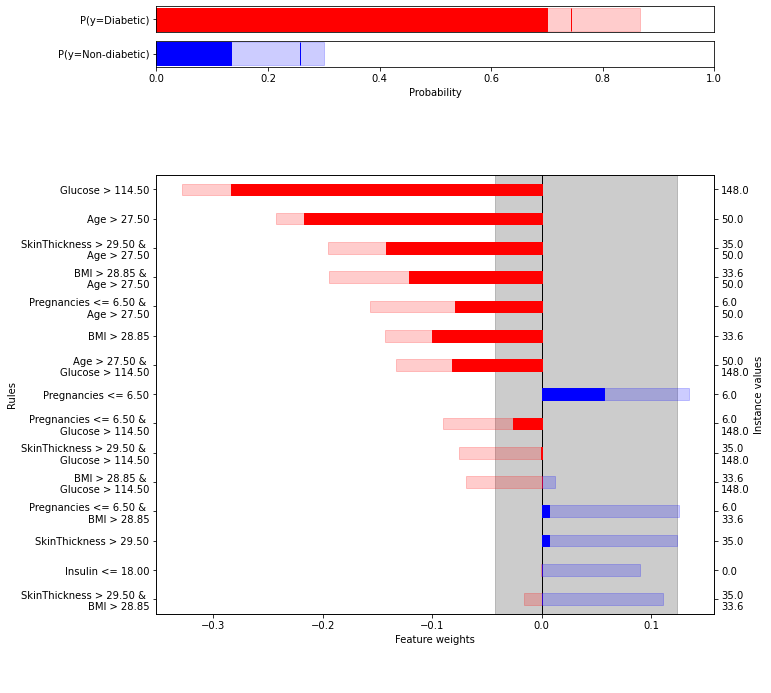

In [10]:
factual_explanation.add_conjunctive_factual_rules()
factual_explanation.plot_all(n_features_to_show=15)
factual_explanation.plot_all(uncertainty=True, n_features_to_show=15)

#### Counterfactual explanations
When using counterfactual explanations, the recommended `Discretizer` is the `EntropyDiscretizer`. The discretizer can be changed into `EntropyDiscretizer` by invoking `set_discretizer('entropy')`. Counterfactual explanations are extracted in the same way as regular and uncertainty explanations. The `EntropyDiscretizer` allows for more varied and precise counterfactual rules. The function `explain_counterfactual` will automatically assign recommended discretizer.

Once the explanations are extracted, we can visualize them using `plot_counterfactuals` plot. The cpunterfactual plot visualize the probability interval for the positive class (`Diabetic` in this example). The counterfactual rules indicate what the interval would have changed into had the feature values changed according to the rule condition.

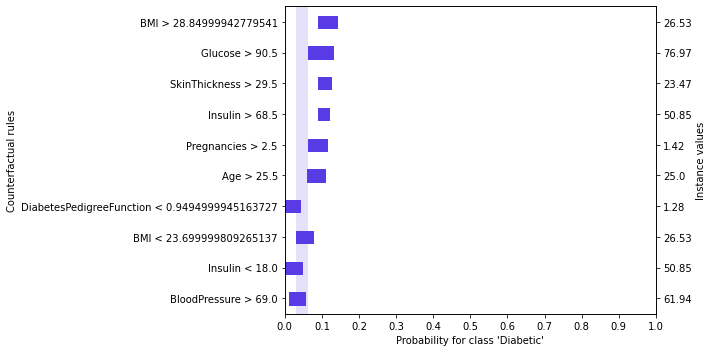

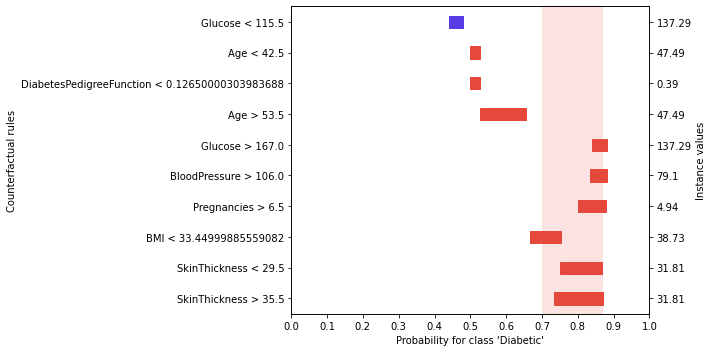

In [11]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation.plot_all()

#### Conjunctional counterfactual explanations
As with regular and uncertainty explanations, conjunctions can also be used for counterfactual explanations.

As the `add_conjunctive...` functions return the explanation object, they can be stacked.

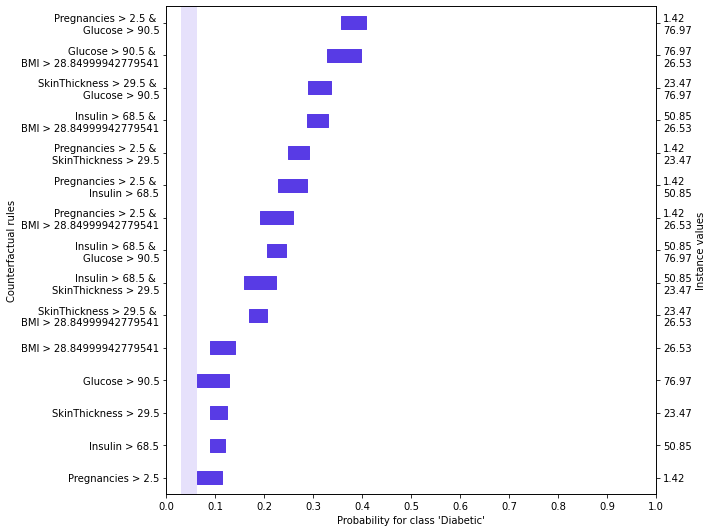

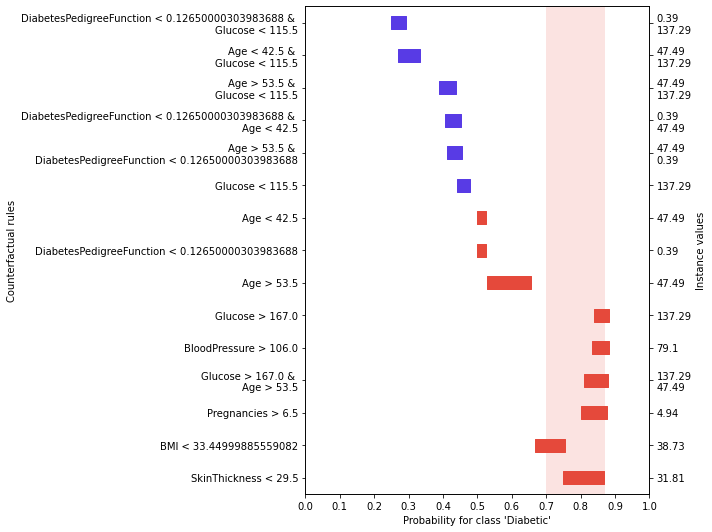

In [12]:
counterfactual_explanation.add_conjunctive_counterfactual_rules().plot_all(n_features_to_show=15)